## In this notebook we will implement a DBSCAN clustering algorithm on the animal zoo dataset

In [1]:
#Import statements 

import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

import umap
import umap.plot as uplot

from sklearn.cluster import DBSCAN 
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
from sklearn.metrics import adjusted_rand_score

from hdbscan.validity import validity_index

sns.set_theme()

/opt/anaconda3/envs/venvum/lib/python3.10/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/opt/anaconda3/envs/venvum/lib/python3.10/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/opt/anaconda3/envs/venvum/lib/python3.10/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, e

The Zoo Dataset is a comprehensive collection of data about various animals found in zoos worldwide. The dataset is composed of several attributes related to these animals, such as:

- `animal_name`: The name of the animal.

- `hair`: Indicates if the animal has hair (1 for yes, 0 for no).
- `feathers`: Indicates if the animal has feathers (1 for yes, 0 for no).
- `eggs`: Indicates if the animal lays eggs (1 for yes, 0 for no).
- `milk`: Indicates if the animal produces milk (1 for yes, 0 for no).
- `airborne`: Indicates if the animal can fly (1 for yes, 0 for no).
- `aquatic`: Indicates if the animal lives in water (1 for yes, 0 for no).
- `predator`: Indicates if the animal is a predator (1 for yes, 0 for no).
- `toothed`: Indicates if the animal has teeth (1 for yes, 0 for no).
- `backbone`: Indicates if the animal has a backbone (1 for yes, 0 for no).
- `breathes`: Indicates if the animal breathes air (1 for yes, 0 for no).
- `venomous`: Indicates if the animal is venomous (1 for yes, 0 for no).
- `fins`: Indicates if the animal has fins (1 for yes, 0 for no).
- `legs`: Number of legs the animal has (integer value).
- `tail`: Indicates if the animal has a tail (1 for yes, 0 for no).
- `domestic`: Indicates if the animal is domesticated (1 for yes, 0 for no).
- `catsize`: Indicates if the animal is cat-sized or larger (1 for yes, 0 for no).
- `class_type`: Numerical code indicating the animal's taxonomic class.


Citation : Forsyth,Richard. (1990). Zoo. UCI Machine Learning Repository. https://doi.org/10.24432/C5R59V.

In [5]:
#Load the data 
# Load the data
zoo_path = '../Aglo-hierarchical-clustering/zoo.csv'
zoo_df = pd.read_csv(zoo_path)

# Load class mapping
class_mappings = '../Aglo-hierarchical-clustering/class.csv'
class_mapper = pd.read_csv(class_mappings)

In [6]:
zoo_df

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,wallaby,1,0,0,1,0,0,0,1,1,1,0,0,2,1,0,1,1
97,wasp,1,0,1,0,1,0,0,0,0,1,1,0,6,0,0,0,6
98,wolf,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1
99,worm,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,7


In [7]:
zoo_df.head()

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1


In [8]:
class_mapper

,Class_Number,Number_Of_Animal_Species_In_Class,Class_Type,Animal_Names
0,1,41,Mammal,"aardvark, antelope, bear, boar, buffalo, calf,..."
1,2,20,Bird,"chicken, crow, dove, duck, flamingo, gull, haw..."
2,3,5,Reptile,"pitviper, seasnake, slowworm, tortoise, tuatara"
3,4,13,Fish,"bass, carp, catfish, chub, dogfish, haddock, h..."
4,5,4,Amphibian,"frog, frog, newt, toad"
5,6,8,Bug,"flea, gnat, honeybee, housefly, ladybird, moth..."
6,7,10,Invertebrate,"clam, crab, crayfish, lobster, octopus, scorpi..."


In [9]:
zoo_df.shape

(101, 18)

In [10]:
zoo_df.isna().sum(axis=0)

animal_name    0
hair           0
feathers       0
eggs           0
milk           0
airborne       0
aquatic        0
predator       0
toothed        0
backbone       0
breathes       0
venomous       0
fins           0
legs           0
tail           0
domestic       0
catsize        0
class_type     0
dtype: int64

In [11]:
# Check number of unique animals 
zoo_df['animal_name'].nunique()

100

In [12]:
# Drop duplicates since there should be one species per row
zoo_df = zoo_df.drop_duplicates('animal_name')
zoo_df.shape

(100, 18)

In [13]:
# Map class id to class name
class_map_dict = class_mapper.set_index('Class_Number')['Class_Type'].to_dict()
zoo_df['class_type'] = zoo_df['class_type'].map(class_map_dict)

# Extract class as separate object and drop class from zoo_df
animal_class = zoo_df['class_type'] 
zoo_df = zoo_df.drop(columns=['class_type'])

/var/folders/h2/hlt0n3hj3jx4phv5m7ncq2180000gn/T/ipykernel_4939/163122117.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zoo_df['class_type'] = zoo_df['class_type'].map(class_map_dict)


In [14]:
# Set animal name as index
zoo_df = zoo_df.set_index('animal_name', drop=True)

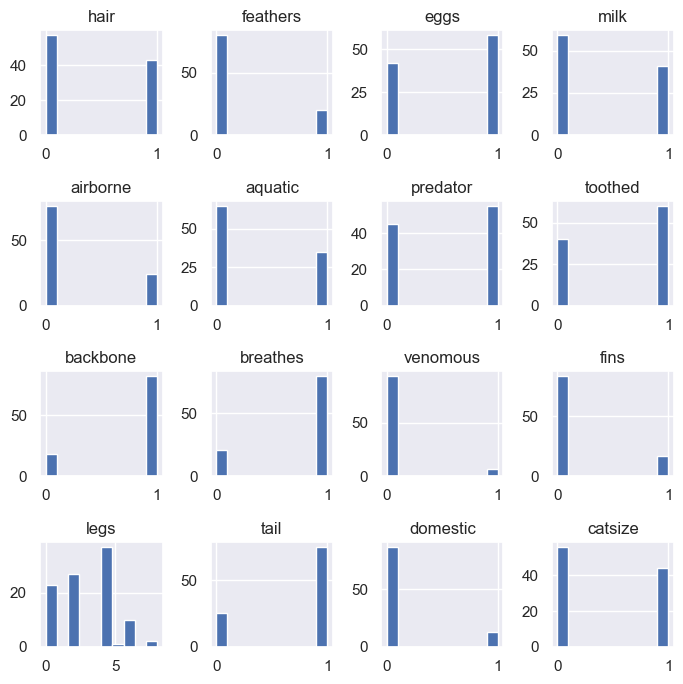

In [15]:
_ = zoo_df.hist(figsize=(7,7))
plt.tight_layout()

## DBSCAN Implementation 

/opt/anaconda3/envs/venvum/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/venvum/lib/python3.10/site-packages/umap/umap_.py:1887: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


<Axes: >

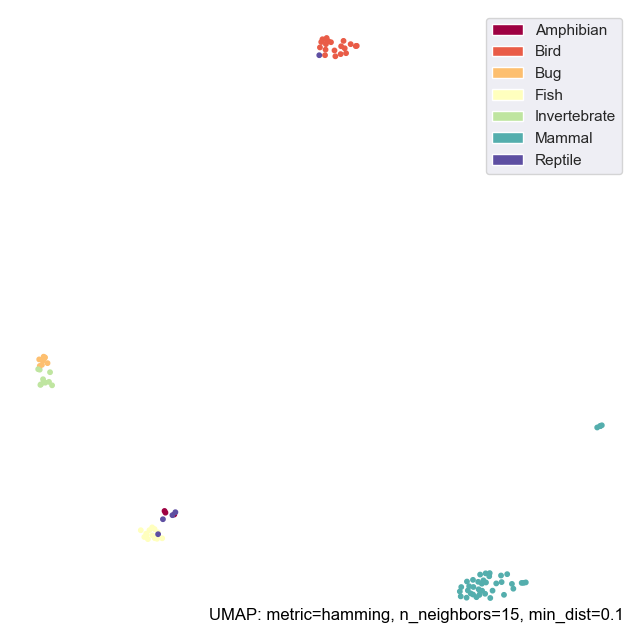

In [16]:
# Default values
umap_obj = umap.UMAP(metric='hamming')
embedding = umap_obj.fit_transform(zoo_df.to_numpy())

uplot.points(umap_obj, labels=animal_class)

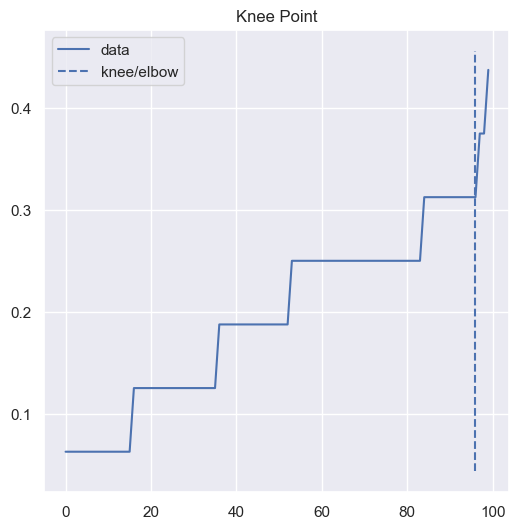

In [17]:
# Identify MinPts
min_pts = zoo_df.shape[1] + 1

# Find distances to min_pts'th neighbor
knn = NearestNeighbors(metric='hamming')
knn.fit(zoo_df)
distances, _ = knn.kneighbors(zoo_df, n_neighbors=min_pts)


# Sort the distances to the min_pts'th neighbor
sort_dist = np.sort(distances[:,-1])

kneedle = KneeLocator(
    range(sort_dist.shape[0]), 
    sort_dist, 
    S=1.0, 
    curve="convex", 
    direction="increasing"
)
kneedle.plot_knee()

<Axes: >

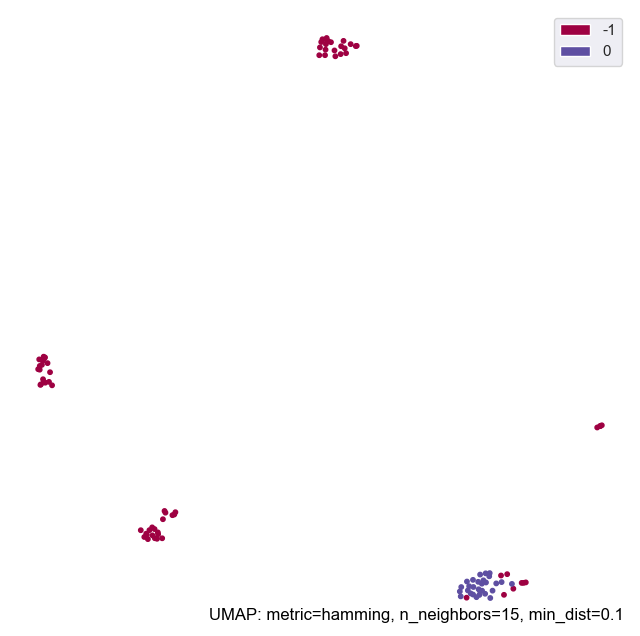

In [18]:
# Cluster 
dbscan = DBSCAN(eps=0.12, min_samples=min_pts, metric='hamming')
_ = dbscan.fit(zoo_df)

uplot.points(umap_obj, labels=dbscan.labels_)

In [20]:
# Identify MinPts
min_pts = int(np.log(zoo_df.shape[0]))
min_pts

4

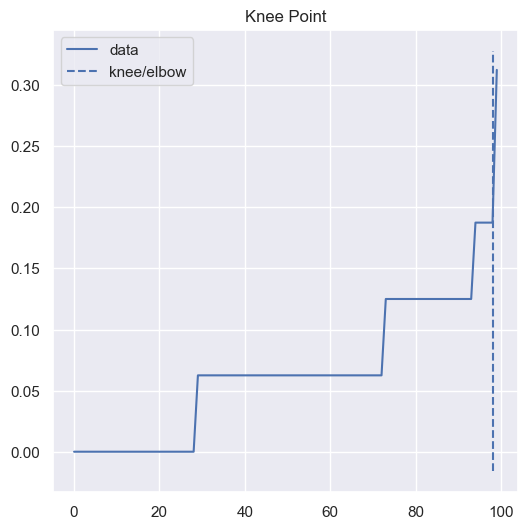

In [ ]:
# Find distances to min_pts'th neighbor
knn = NearestNeighbors(metric='hamming')
knn.fit(zoo_df)
distances, _ = knn.kneighbors(zoo_df, n_neighbors=min_pts)


# Sort the distances to min_pts'th neighbor
sort_dist = np.sort(distances[:,-1])

kneedle = KneeLocator(
    range(sort_dist.shape[0]), 
    sort_dist, 
    S=1.0, 
    curve="convex", 
    direction="increasing"
)
kneedle.plot_knee()

<Axes: >

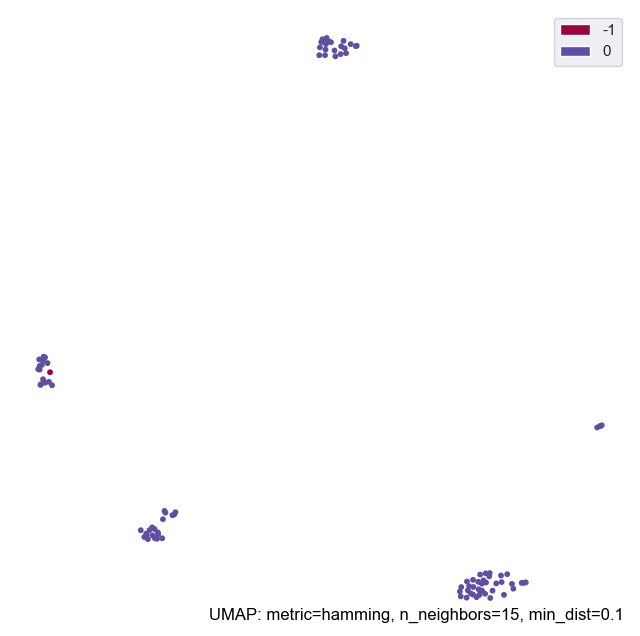

In [22]:
dbscan = DBSCAN(eps=0.19, min_samples=min_pts, metric='hamming')
_ = dbscan.fit(zoo_df)

uplot.points(umap_obj, labels=dbscan.labels_)

<Axes: >

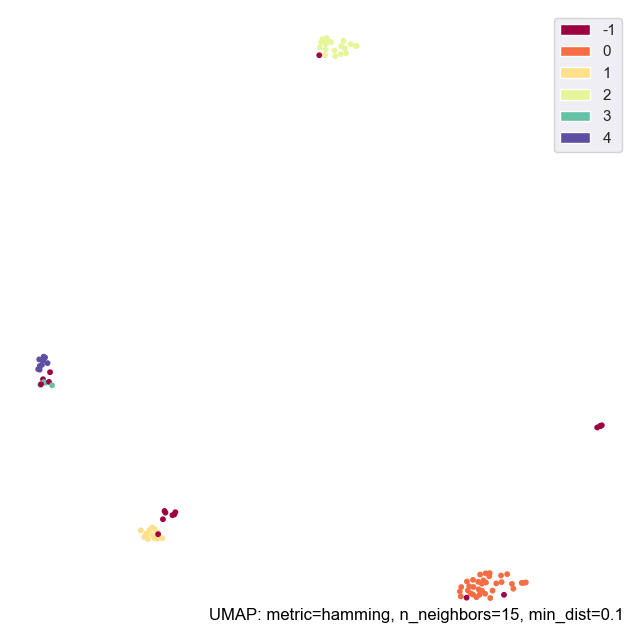

In [23]:
dbscan = DBSCAN(eps=0.124, min_samples=min_pts, metric='hamming')
_ = dbscan.fit(zoo_df)

uplot.points(umap_obj, labels=dbscan.labels_)

In [24]:
validity_index(
    X=zoo_df.to_numpy(), 
    labels=dbscan.labels_, 
    metric='hamming', 
    per_cluster_scores=True
)

(0.6127542191897047,
 array([0.75068628, 0.79114531, 0.72442929, 0.74358365, 0.72535926]))

<Axes: >

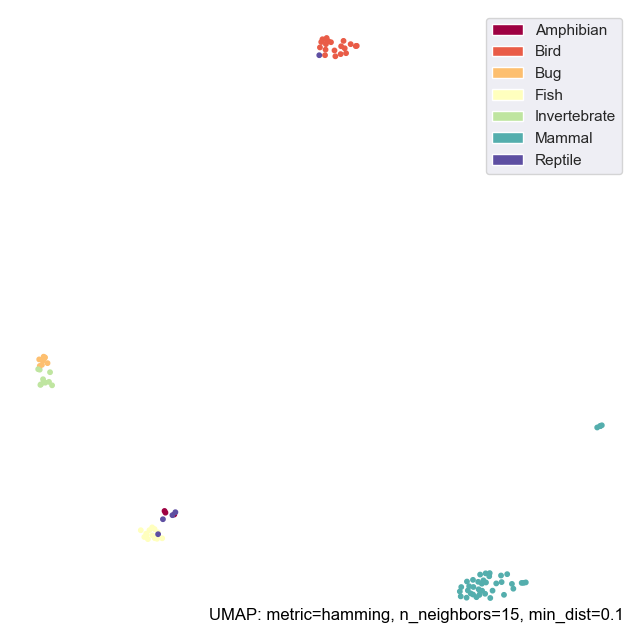

In [25]:
uplot.points(umap_obj, labels=animal_class)

In [26]:
adjusted_rand_score(animal_class, dbscan.labels_)

0.7826933472013362

In [27]:
animal_class

0            Mammal
1            Mammal
2              Fish
3            Mammal
4            Mammal
           ...     
96           Mammal
97              Bug
98           Mammal
99     Invertebrate
100            Bird
Name: class_type, Length: 100, dtype: object